# What impact does emotional tone (anger, sadness, anxiety, joy, gratitude, and hopefulness) in prompts have on the Large Language Model responses?

Which emotion has the highest impact on quality in LLM responses? We believe that such emotions (anger, sadness, and anxiety) may have varying effects on LLM output quality. For example, prompts with high anxiety may produce 'better' prompts because the model could sense the urgency in the situation.

How can we do this? We must curate public datasets of real conversations between users and LLMs. In this project we will primarily be working with WildChat and ShareGPT52k, which hold around 1 million conversations.

To analyze emotional tone in prompts, we utilize a proprietary service, LIWC, that calculates the percentage of words in a sentence that relates to specific categories. To measure Large Language Model responses, we will use perplexity, readability, and lexical diversity metrics. Additionally, we use matplotlib and seaborn to visualize our findings.

In step 1 we load the data from HuggingFace and filter them based on keywords we believe pertain to the outputs we're measuring

In [17]:
# Import datasets
from datasets import load_dataset
wildchat = load_dataset("allenai/WildChat-1M", split='train')
sharegpt = load_dataset('RyokoAI/ShareGPT52K', split='train', streaming=True)

In [18]:
wildchat_convo = []

MAX_WORD_COUNT = 50  # Set a reasonable word count limit for prompts

for conversation in wildchat['conversation']:
    # Collect only the first turn of each conversation
    user_turn = conversation[0]

    if user_turn.get('language') == "English":
        prompt = user_turn.get('content', '').strip().lower()

        # Ensure the prompt is not too large
        if len(prompt.split()) < MAX_WORD_COUNT:
            wildchat_convo.append({
                'prompt': user_turn['content'],
                'response': conversation[1].get('content', '').strip() if len(conversation) > 1 else ''
            })
            
    if len(wildchat_convo) >= 150:
        break

In [19]:
from langdetect import detect

sharegpt_convo = []

# Helper function
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

MAX_WORD_COUNT = 50  # Set a reasonable word count limit

for example in sharegpt:
    messages = example.get("conversations", [])

    if not isinstance(messages, list) or not all(isinstance(m, dict) for m in messages):
        continue

    if len(messages) < 2:
        continue  # Need at least one user and one assistant message

    user = messages[0]
    bot = messages[1]

    prompt = user.get("value", "").strip()
    response = bot.get("value", "").strip()

    if (
        is_english(prompt)
        and is_english(response)
        and len(prompt.split()) < MAX_WORD_COUNT
    ):
        sharegpt_convo.append({"prompt": prompt, "response": response})

    if len(sharegpt_convo) >= 150:
        break

In [20]:
convos = wildchat_convo + sharegpt_convo

In step 2, we will run our natural prompts through LangChain using the gemma2-9b-it and llama-3.3-70b-versatile supported models to variate our prompts and produce corresponding model responses

In [22]:
!pip install --quiet langchain langchain-groq  langchain-core

GROQ_API_KEY=""

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

chat = ChatGroq(temperature=2, groq_api_key=GROQ_API_KEY, model_name="gemma2-9b-it") # And 'llama-3.3-70b-versatile'

In [23]:
system = "You are an assistant."
human = "{text}"
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
chain = prompt | chat

def emo_gen(text, emotion):
    response = chain.invoke({
        "text": f"""Generate 5 rephrasings of the following prompt that reflect increasing levels of {emotion}, from 1 (very mild) to 5 (extremely intense). 
Number each version on a new line like this (keep your answer between 150-200 words with no emojis):

1. [mild {emotion}]
2. [slightly more intense {emotion}]
3. ...
5. [most intense {emotion}]

Prompt: "{text}"
"""
    })
    return response.content

In [25]:
import re

pattern = r"(?m)^(\d+)\.\s+(.*)"

anger_prompts = []
sad_prompts = []
anxious_prompts = []

joyful_prompts = []
gratitude_prompts = []
hopeful_prompts = []

for row in convos:
    prompt = row['prompt']

    anger_prompt = emo_gen(prompt, "anger")
    sad_prompt = emo_gen(prompt, "sadness")
    anxious_prompt = emo_gen(prompt, "anxious")

    joyful_prompt = emo_gen(prompt, "Joyfulness")
    gratitude_prompt = emo_gen(prompt, "Gratitude")
    hopeful_prompt = emo_gen(prompt, "Hopefulness")
    
    anger_sentences = [s for _, s in re.findall(pattern, anger_prompt)]
    sad_sentences = [s for _, s in re.findall(pattern, sad_prompt)]
    anxious_sentences = [s for _, s in re.findall(pattern, anxious_prompt)]

    joyful_sentences = [s for _, s in re.findall(pattern, joyful_prompt)]
    gratitude_sentences = [s for _, s in re.findall(pattern, gratitude_prompt)]
    hopeful_sentences = [s for _, s in re.findall(pattern, hopeful_prompt)]
    
    if len(anger_sentences) == 5:
        anger_prompts.append(anger_sentences)
    if len(sad_sentences) == 5:
        sad_prompts.append(sad_sentences)
    if len(anxious_sentences) == 5:
        anxious_prompts.append(anxious_sentences)

    if len(joyful_sentences) == 5:
        joyful_prompts.append(joyful_sentences)
    if len(gratitude_sentences) == 5:
        gratitude_prompts.append(gratitude_sentences)
    if len(hopeful_sentences) == 5:
        hopeful_prompts.append(hopeful_sentences)

In [ ]:
from tqdm import tqdm

def generate_emotion_responses(prompt_groups, label="Emotion"):
    output = []

    for prompt_group in tqdm(prompt_groups, desc=f"Generating responses for {label}"):
        for i, prompt_text in enumerate(prompt_group):
            intensity = i + 1  # Levels 1–5

            try:
                response = chain.invoke({
                    "text": f"{prompt_text}\n\n(Keep your answer between 300-400 words with no emojis.)"
                })

                output.append({
                    "intensity": intensity,
                    "prompt": prompt_text,
                    "response": response.content
                })

            except Exception as e:
                print(f"[{label}] Error with prompt: {prompt_text}\n{e}")
    
    return output

anger_convos = generate_emotion_responses(anger_prompts, label="Anger")
sad_convos = generate_emotion_responses(sad_prompts, label="Sad")
anxious_convos = generate_emotion_responses(anxious_prompts, label="Anxious")

joyful_convos = generate_emotion_responses(joyful_prompts, label="Joyfulness")
gratitude_convos = generate_emotion_responses(gratitude_prompts, label="Gratitude")
hopeful_convos = generate_emotion_responses(hopeful_prompts, label="Hopefulness")

In [27]:
import json

convos = {
    "anger": anger_convos,
    "sad": sad_convos,
    "anxious": anxious_convos,
    "joyful": joyful_convos,
    "gratitude": gratitude_convos,
    "hopeful": hopeful_convos
}

with open("gemma_convos.json", "w") as f:
    json.dump(convos, f, indent=2)

In step 3, we measure our outputs using metrics of perplexity, lexical diversity, and readability.

In [ ]:
import os
import json
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# --- Perplexity Calculator ---
class PerplexityCalculator:
    def __init__(self, model_name='gpt2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(
            torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )
    def perplexity(self, text):
        enc = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=1024).to(self.model.device)
        with torch.no_grad():
            loss = self.model(**enc, labels=enc['input_ids']).loss
        return torch.exp(loss).item()

# --- Lexical diversity ---
def lexical_diversity(text):
    tokens = word_tokenize(text.lower())
    return len(set(tokens)) / len(tokens) if tokens else 0.0

# --- Evaluate a list of responses ---
def evaluate_data(data, pp_calc):
    records = []
    for item in data:
        resp = item.get('response', '')
        records.append({
            'intensity': item.get('intensity', None),
            'readability': textstat.flesch_reading_ease(resp),
            'perplexity': pp_calc.perplexity(resp),
            'lex_diversity': lexical_diversity(resp)
        })
    return pd.DataFrame(records)

# --- Main ---
def main():
    # Load JSON files
    model_files = {
        'gemma': 'gemma_convos.json',
        'llama': 'llama_convos.json'
    }

    # Initialize perplexity calculator
    pp_calc = PerplexityCalculator('gpt2')

    # Storage for all results
    all_metrics = {}

    for model_name, filepath in model_files.items():
        if not os.path.exists(filepath):
            print(f"❌ File not found: {filepath}")
            continue

        with open(filepath, 'r') as f:
            model_data = json.load(f)  # This is a dict of emotion → list of dicts

        all_metrics[model_name] = {}

        for emotion, responses in model_data.items():
            print(f"▶ Evaluating {model_name} / {emotion}...")
            df = evaluate_data(responses, pp_calc)
            all_metrics[model_name][emotion] = df

            out_file = f"{model_name}_{emotion}_metrics.csv"
            df.to_csv(out_file, index=False)
            print(f"✔ Saved → {out_file}")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import textstat
import numpy as np
import math
from sklearn.feature_extraction.text import CountVectorizer

# Load the CSV
df = pd.read_csv("conversations/original_convos.csv")  # Replace with your actual file path

# Define metric functions
def calc_readability(text):
    try:
        return textstat.flesch_reading_ease(text)
    except:
        return np.nan

def calc_perplexity(text):
    try:
        # Fake perplexity example using entropy; replace with real model if needed
        words = text.split()
        if not words:
            return np.nan
        prob = 1 / len(set(words))
        entropy = -math.log2(prob)
        return math.pow(2, entropy)
    except:
        return np.nan

def calc_lexical_diversity(text):
    try:
        words = text.split()
        return len(set(words)) / len(words) if words else 0
    except:
        return np.nan

# Apply metrics to 'response' column
df["readability"] = df["response"].apply(calc_readability)
df["perplexity"] = df["response"].apply(calc_perplexity)
df["lex_diversity"] = df["response"].apply(calc_lexical_diversity)

# Save results
df.to_csv("original_metrics.csv", index=False)
print("Metrics calculated and saved to 'output_with_metrics.csv'.")

In Step 4 we correlate our LIWC results with our metric results

In [81]:
# List of emotions
emotions = ['anger', 'anxious', 'joyful', 'sad', 'gratitude', 'hopeful']

# Directory paths
convos_dir = "llama_convos_csv"
metrics_dir = "metric_results"
liwc_dir = "llama_liwc scores"

# Storage for all combined DataFrames
combined_emotion_dfs = {}

for emotion in emotions:
    # File paths
    convos_path = os.path.join(convos_dir, f"{emotion}_convos.csv")
    metrics_path = os.path.join(metrics_dir, f"llama_{emotion}_metrics.csv")
    liwc_path = os.path.join(liwc_dir, f"LIWC-22 Results - {emotion}_convos - LIWC Analysis.csv")

    # Load CSVs
    convos_df = pd.read_csv(convos_path).reset_index(drop=True)
    metrics_df = pd.read_csv(metrics_path).reset_index(drop=True)
    liwc_df = pd.read_csv(liwc_path).reset_index(drop=True)

    # Drop redundant columns
    liwc_df = liwc_df.drop(columns=['intensity', 'prompt', 'response'], errors='ignore')
    metrics_df = metrics_df.drop(columns=['intensity'])

    # Merge all
    combined_df = pd.concat([convos_df, metrics_df, liwc_df], axis=1)

    # Save in dictionary
    combined_emotion_dfs[emotion] = combined_df

original_convos = pd.read_csv("conversations/original_convos.csv")
original_metrics = pd.read_csv("metric_results/original_metrics.csv")

original_convos = original_convos.reset_index(drop=True)
original_metrics = original_metrics.reset_index(drop=True)
original_df = pd.concat([original_convos, original_metrics], axis=1)

combined_emotion_dfs['original'] = original_df

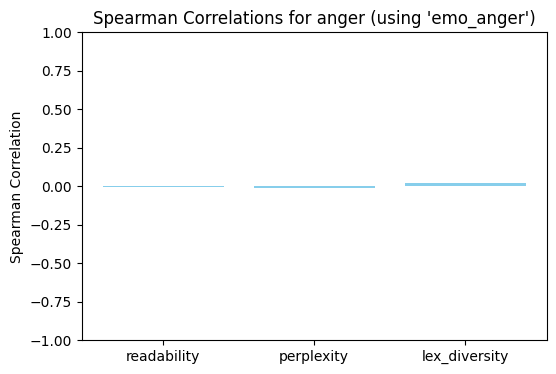

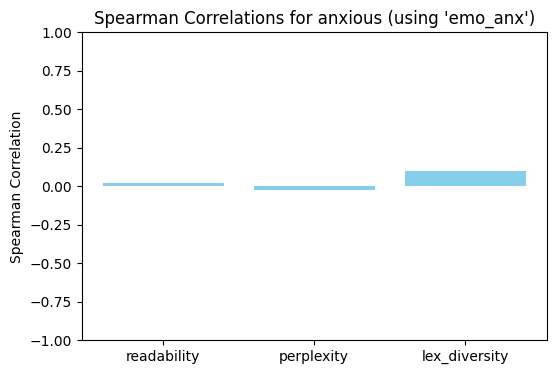

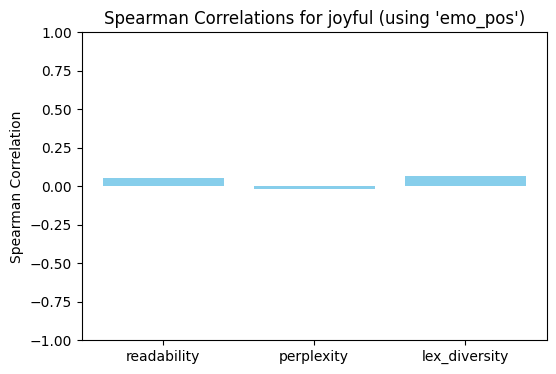

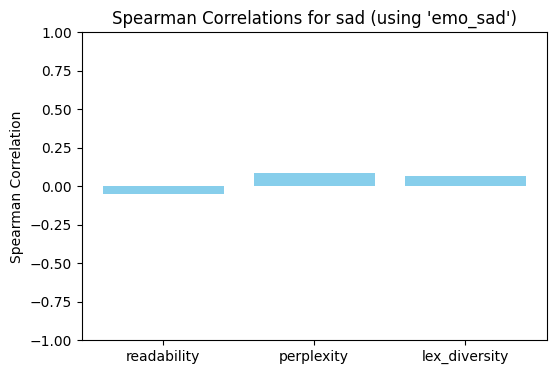

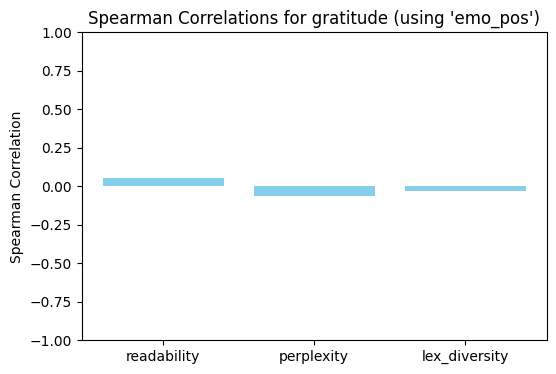

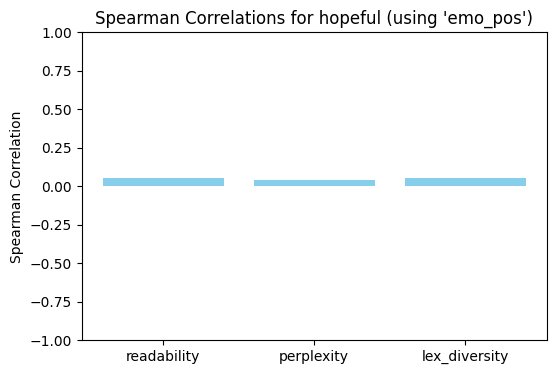

In [45]:
import matplotlib.pyplot as plt

for emotion in emotions:
    df = combined_emotion_dfs.get(emotion)
    emo_col = get_emo_col(emotion)
    if df is None or emo_col not in df.columns:
        continue

    metric_corrs = []
    for metric in metrics_cols:
        if metric in df.columns:
            corr = df[emo_col].corr(df[metric], method='spearman')
            metric_corrs.append((metric, corr))

    metrics, corrs = zip(*metric_corrs)
    plt.figure(figsize=(6,4))
    plt.bar(metrics, corrs, color='skyblue')
    plt.ylim(-1, 1)
    plt.title(f"Spearman Correlations for {emotion} (using '{emo_col}')")
    plt.ylabel("Spearman Correlation")
    plt.show()


Given the weak correlation observed between the LIWC category scores and our linguistic quality metrics, we conclude that relying solely on LIWC scores is insufficient to capture the emotional dynamics influencing LLM-generated responses. Simply correlating the number of emotional words may not be enough. Therefore, moving forward, we focus on emotion intensity as a more sensitive and continuous measure that better aligns with variations in language quality.

This shift will allow a more precise investigation of how the strength of emotional stimuli impacts model outputs.

Next we will want to visualize our metrics results for each emotion and the original.

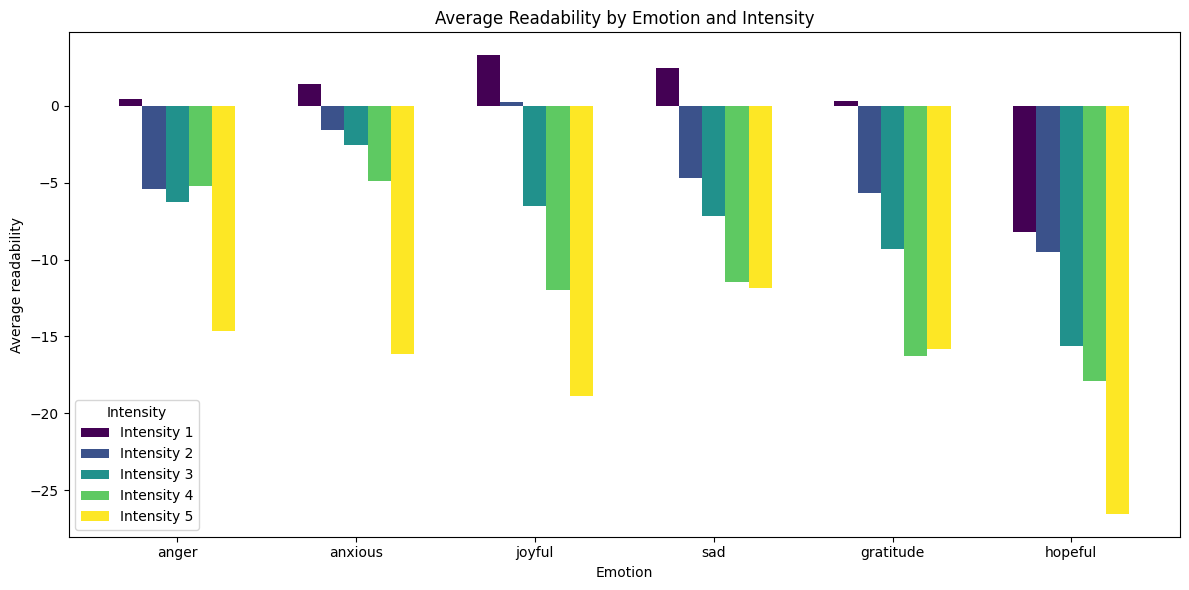

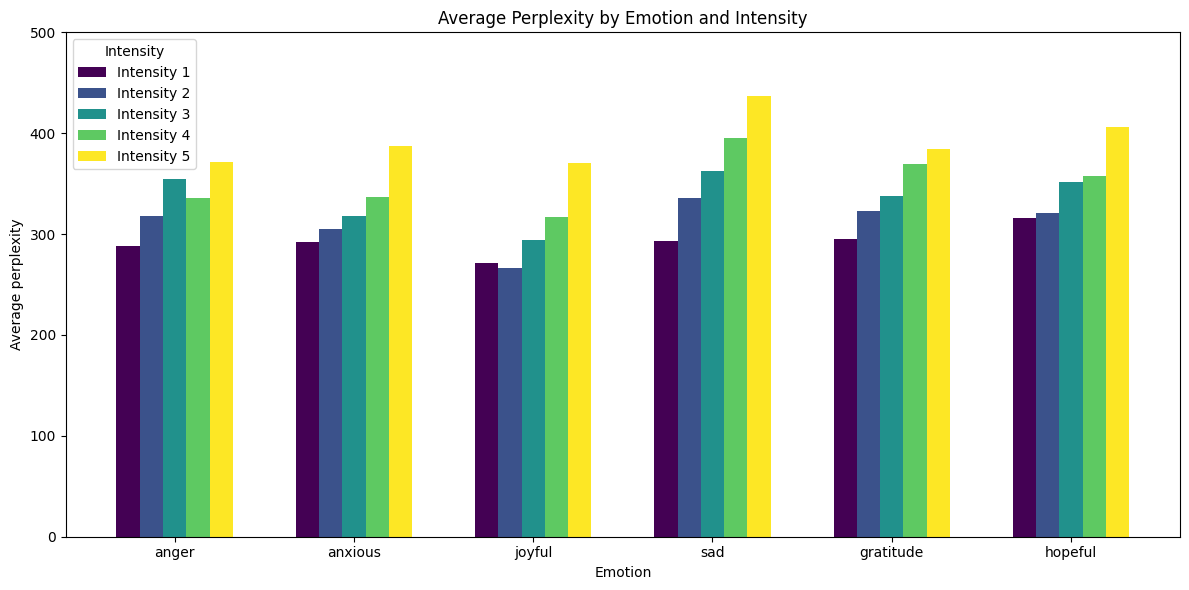

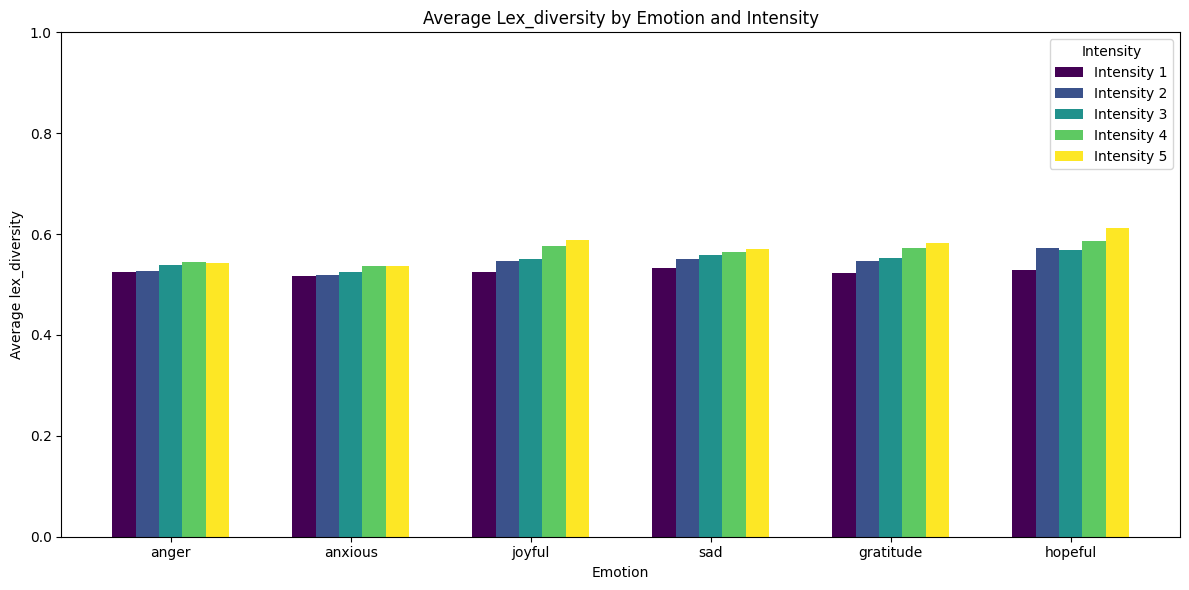

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metrics = ['readability', 'perplexity', 'lex_diversity']
emotions = ['anger', 'anxious', 'joyful', 'sad', 'gratitude', 'hopeful']
intensity_levels = [1, 2, 3, 4, 5]

colors = plt.cm.viridis(np.linspace(0, 1, len(intensity_levels)))

# Plot for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.13 
    x = np.arange(len(emotions)) 

    # For each intensity level
    for i, intensity in enumerate(intensity_levels):
        averages = []
        for emotion in emotions:
            df = combined_emotion_dfs[emotion]
            subset = df[df['intensity'] == intensity]
            avg = subset[metric].mean()
            averages.append(avg)
        ax.bar(x + i * width, averages, width, label=f'Intensity {intensity}', color=colors[i])

    ax.set_title(f'Average {metric.capitalize()} by Emotion and Intensity')
    ax.set_xlabel('Emotion')
    ax.set_ylabel(f'Average {metric}')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(emotions)
    ax.legend(title='Intensity')
    if (metric == "lex_diversity"):
        plt.ylim(top=1)
    elif (metric == "perplexity"):
        plt.ylim(top=500)
    plt.tight_layout()
    plt.show()

In [217]:
# Hard coding this for now, will clean up later
import json

with open('conversations/gemma_convos.json', 'r') as f:
    data = json.load(f)

gemma_anger_metrics = pd.read_csv('metric_results/gemma_anger_metrics.csv')
gemma_anxious_metrics = pd.read_csv('metric_results/gemma_anxious_metrics.csv')
gemma_gratitude_metrics = pd.read_csv('metric_results/gemma_gratitude_metrics.csv')
gemma_hopeful_metrics = pd.read_csv('metric_results/gemma_hopeful_metrics.csv')
gemma_joyful_metrics = pd.read_csv('metric_results/gemma_joyful_metrics.csv')
gemma_sad_metrics = pd.read_csv('metric_results/gemma_sad_metrics.csv')

gemma_anger_convos = pd.DataFrame(data['anger']).drop(columns=['intensity'])
gemma_anxious_convos = pd.DataFrame(data['anxious']).drop(columns=['intensity'])
gemma_gratitude_convos = pd.DataFrame(data['gratitude']).drop(columns=['intensity'])
gemma_hopeful_convos = pd.DataFrame(data['hopeful']).drop(columns=['intensity'])
gemma_joyful_convos = pd.DataFrame(data['joyful']).drop(columns=['intensity'])
gemma_sad_convos = pd.DataFrame(data['sad']).drop(columns=['intensity'])

anger_df = pd.concat([gemma_anger_convos, gemma_anger_metrics], axis=1)
anxious_df = pd.concat([gemma_anxious_convos, gemma_anxious_metrics], axis=1)
gratitude_df = pd.concat([gemma_gratitude_convos, gemma_gratitude_metrics], axis=1)
hopeful_df = pd.concat([gemma_hopeful_convos, gemma_hopeful_metrics], axis=1)
joyful_df = pd.concat([gemma_joyful_convos, gemma_joyful_metrics], axis=1)
sad_df = pd.concat([gemma_sad_convos, gemma_sad_metrics], axis=1)

gemma_combined_emotions_dfs = {
    'anger': anger_df,
    'anxious': anxious_df,
    'gratitude': gratitude_df,
    'hopeful': hopeful_df,
    'joyful': joyful_df,
    'sad': sad_df,
}

In [219]:
gemma_combined_emotions_dfs['anger']

,prompt,response,intensity,readability,perplexity,lex_diversity
0,Could you provide me with some free apps that ...,I can guide you towards some free applications...,1,18.719318,396.513977,0.585145
1,I'm looking for free app recommendations that ...,While perfection may be unattainable when conv...,2,33.940511,431.255798,0.472665
2,Does anyone know of any free apps that are cap...,Given MP3 files lack detailed musical informat...,3,22.436340,425.700989,0.671642
3,"Seriously, does anyone have suggestions for so...","Finding zuverlässige, free multi-purpose platf...",4,14.522767,387.906158,0.691218
4,"I need free app suggestions, and yes, _free i...",Finding free mobile applications that directly...,5,43.121420,509.073090,0.639775
...,...,...,...,...,...,...
370,"""Excuse me, Could you perhaps guide me through...",I'd be glad to introduce you to the world of c...,1,44.460745,35.822002,0.539007
371,"""I would appreciate instruction on basic codin...",Understanding basic coding concepts can indeed...,2,48.349518,259.092010,0.518664
372,"""I need help with my computer program. It woul...",Tell me about your struggling program! I'll do...,3,36.163810,327.661865,0.772727
373,If one sentence can adequately express pure di...,There's tension simmering merely backstage wit...,4,56.162607,585.069336,0.478599


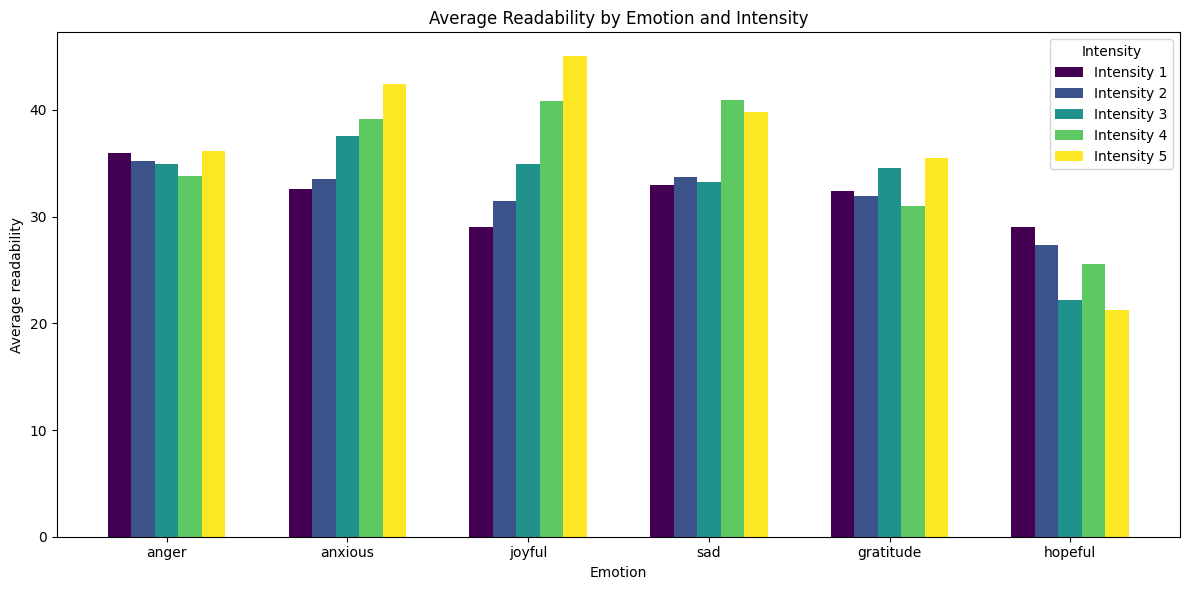

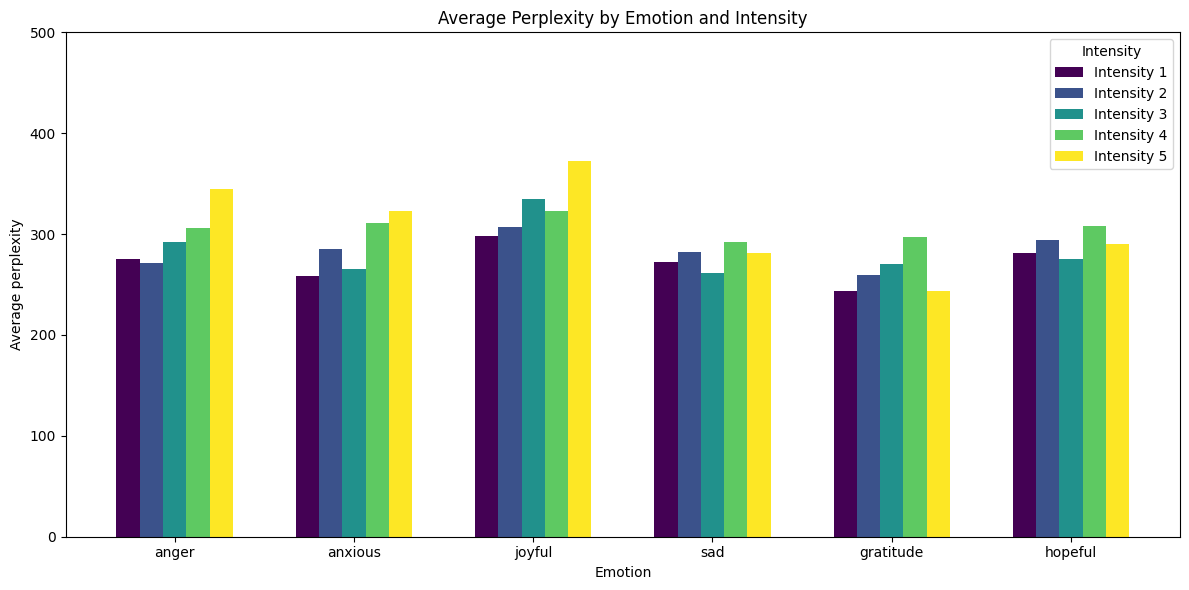

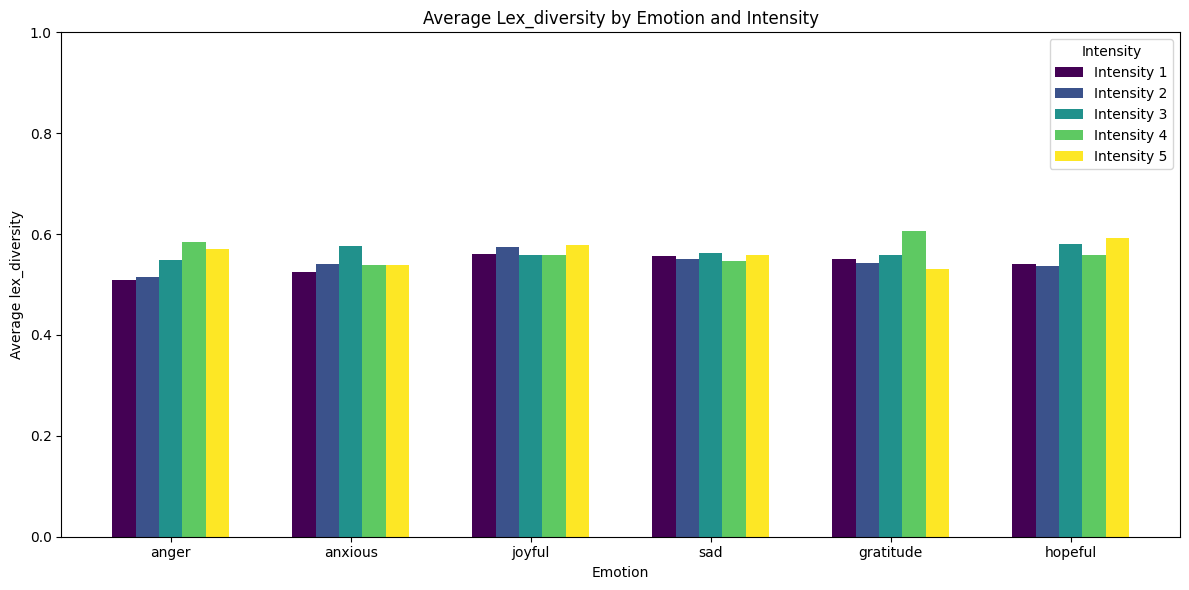

In [225]:
# Plot for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.13 
    x = np.arange(len(emotions)) 

    # For each intensity level
    for i, intensity in enumerate(intensity_levels):
        averages = []
        for emotion in emotions:
            df = gemma_combined_emotions_dfs[emotion]
            subset = df[df['intensity'] == intensity]
            avg = subset[metric].mean()
            averages.append(avg)
        ax.bar(x + i * width, averages, width, label=f'Intensity {intensity}', color=colors[i])

    ax.set_title(f'Average {metric.capitalize()} by Emotion and Intensity')
    ax.set_xlabel('Emotion')
    ax.set_ylabel(f'Average {metric}')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(emotions)
    ax.legend(title='Intensity')
    if (metric == "lex_diversity"):
        plt.ylim(top=1)
    elif (metric == "perplexity"):
        plt.ylim(top=500)
    plt.tight_layout()
    plt.show()